In [52]:
import pandas as pd
import numpy as np
import datetime
import yfinance as yf

from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl import config_tickers
from finrl.config import INDICATORS
import optuna

import itertools

In [53]:
TRAIN_START_DATE = '2025-01-23'
TRAIN_END_DATE = '2025-02-13'
TRADE_START_DATE = '2025-02-14'
TRADE_END_DATE = '2025-03-10'

In [54]:
from datetime import datetime, timedelta
df_aapl_raw = yf.download(tickers = "aapl", start=TRAIN_START_DATE, end=TRADE_END_DATE, interval='15m')
# end_date = datetime.today().strftime('%Y-%m-%d')
# start_date = (datetime.today() - timedelta(days=20)).strftime('%Y-%m-%d')

# df_aapl_raw = yf.download(tickers = "aapl", start=start_date, end=end_date, interval="15m")

[*********************100%***********************]  1 of 1 completed


In [55]:
print(df_aapl_raw.head())

Price                           Close        High         Low        Open  \
Ticker                           AAPL        AAPL        AAPL        AAPL   
Datetime                                                                    
2025-01-23 14:30:00+00:00  224.770004  226.259995  224.500000  224.729996   
2025-01-23 14:45:00+00:00  225.164993  225.580002  224.259995  224.774994   
2025-01-23 15:00:00+00:00  226.059998  226.100006  224.890305  225.190002   
2025-01-23 15:15:00+00:00  225.970001  227.029999  225.845001  226.059998   
2025-01-23 15:30:00+00:00  226.169998  226.369995  225.520004  225.964996   

Price                       Volume  
Ticker                        AAPL  
Datetime                            
2025-01-23 14:30:00+00:00  6234470  
2025-01-23 14:45:00+00:00  2367934  
2025-01-23 15:00:00+00:00  2761257  
2025-01-23 15:15:00+00:00  2952351  
2025-01-23 15:30:00+00:00  1868152  


In [56]:
# 如果列是 MultiIndex，可以使用 droplevel 来去掉第二层（'AAPL'）
if isinstance(df_aapl_raw.columns, pd.MultiIndex):
    # 去掉第二层（'AAPL'），只保留第一个级别
    df_aapl_raw.columns = df_aapl_raw.columns.droplevel(1)

df_aapl_raw.columns = df_aapl_raw.columns.str.lower()
# 显示处理后的结果
print(df_aapl_raw.columns)
print(df_aapl_raw.head())

Index(['close', 'high', 'low', 'open', 'volume'], dtype='object', name='Price')
Price                           close        high         low        open  \
Datetime                                                                    
2025-01-23 14:30:00+00:00  224.770004  226.259995  224.500000  224.729996   
2025-01-23 14:45:00+00:00  225.164993  225.580002  224.259995  224.774994   
2025-01-23 15:00:00+00:00  226.059998  226.100006  224.890305  225.190002   
2025-01-23 15:15:00+00:00  225.970001  227.029999  225.845001  226.059998   
2025-01-23 15:30:00+00:00  226.169998  226.369995  225.520004  225.964996   

Price                       volume  
Datetime                            
2025-01-23 14:30:00+00:00  6234470  
2025-01-23 14:45:00+00:00  2367934  
2025-01-23 15:00:00+00:00  2761257  
2025-01-23 15:15:00+00:00  2952351  
2025-01-23 15:30:00+00:00  1868152  


In [57]:
df_aapl = df_aapl_raw.reset_index()  # 保留索引
print(df_aapl.columns) 
df_aapl['datetime'] = df_aapl['Datetime']
# df_aapl['date'] = df_aapl['Datetime'].dt.date
df_aapl['date'] = pd.to_datetime(df_aapl['Datetime'])
df_aapl['tic'] = "aapl"
df_aapl['day'] = df_aapl['Datetime'].dt.dayofweek 
#remove datetime
df_aapl = df_aapl.drop(['Datetime'], axis=1)
df_aapl = df_aapl[['date', 'close', 'high', 'low', 'open', 'volume', 'tic', 'day']]
if 'adjcp' not in df_aapl.columns:
    df_aapl['adjcp'] = df_aapl['close']
    # df_aapl['adjhigh'] = df_aapl['high']
    # df_aapl['adjlow'] = df_aapl['low']
    # df_aapl['adjopen'] = df_aapl['open']
print(df_aapl.columns)

Index(['Datetime', 'close', 'high', 'low', 'open', 'volume'], dtype='object', name='Price')
Index(['date', 'close', 'high', 'low', 'open', 'volume', 'tic', 'day',
       'adjcp'],
      dtype='object', name='Price')


In [58]:
print(df_aapl["date"].dtype) 

datetime64[ns, UTC]


In [59]:
print(df_aapl.head())

Price                      date       close        high         low  \
0     2025-01-23 14:30:00+00:00  224.770004  226.259995  224.500000   
1     2025-01-23 14:45:00+00:00  225.164993  225.580002  224.259995   
2     2025-01-23 15:00:00+00:00  226.059998  226.100006  224.890305   
3     2025-01-23 15:15:00+00:00  225.970001  227.029999  225.845001   
4     2025-01-23 15:30:00+00:00  226.169998  226.369995  225.520004   

Price        open   volume   tic  day       adjcp  
0      224.729996  6234470  aapl    3  224.770004  
1      224.774994  2367934  aapl    3  225.164993  
2      225.190002  2761257  aapl    3  226.059998  
3      226.059998  2952351  aapl    3  225.970001  
4      225.964996  1868152  aapl    3  226.169998  


In [60]:
INDICATORS_15M = [
    "boll_ub",
    "boll_lb",
    "rsi_30",
    "cci_30",
    "dx_30",
    "close_30_sma",

]

In [61]:

fe = FeatureEngineer(use_technical_indicator=True,
                     tech_indicator_list = INDICATORS_15M,
                     use_vix=False,
                     use_turbulence=False,
                     user_defined_feature = False)

processed = fe.preprocess_data(df_aapl)


Successfully added technical indicators


In [62]:
# Ensure that processed['date'] is a datetime column with full timestamp:
processed['date'] = pd.to_datetime(processed['date'])

# Create a date_range with 5-minute frequency
list_dates = pd.date_range(
    start=processed['date'].min(), 
    end=processed['date'].max(), 
    freq='15min'
)

list_ticker = processed["tic"].unique().tolist()
combination = list(itertools.product(list_dates, list_ticker))

processed_full = pd.DataFrame(combination, columns=["date", "tic"])
# Merge on both "date" and "tic" (here the 'date' in processed has full time info)
processed_full = processed_full.merge(processed, on=["date", "tic"], how="left")
processed_full.sort_values(["date", "tic"], inplace=True)
processed_full.reset_index(drop=True, inplace=True)

# Fill missing values (you can use forward-fill or another method)
processed_full = processed_full.ffill()  # or .bfill() if appropriate

In [63]:
processed_full.head(100)

,date,tic,close,high,low,open,volume,day,adjcp,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma
0,2025-01-23 14:30:00+00:00,aapl,224.770004,226.259995,224.500000,224.729996,6234470.0,3.0,224.770004,225.526098,224.408900,100.000000,-66.666667,100.000000,224.770004
1,2025-01-23 14:45:00+00:00,aapl,225.164993,225.580002,224.259995,224.774994,2367934.0,3.0,225.164993,225.526098,224.408900,100.000000,-66.666667,100.000000,224.967499
2,2025-01-23 15:00:00+00:00,aapl,226.059998,226.100006,224.890305,225.190002,2761257.0,3.0,226.059998,226.653566,224.009764,100.000000,100.000000,39.687424,225.331665
3,2025-01-23 15:15:00+00:00,aapl,225.970001,227.029999,225.845001,226.059998,2952351.0,3.0,225.970001,226.745211,224.237287,93.204041,111.308097,74.173003,225.491249
4,2025-01-23 15:30:00+00:00,aapl,226.169998,226.369995,225.520004,225.964996,1868152.0,3.0,226.169998,226.871135,224.382862,94.122327,59.383228,43.518110,225.626999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,2025-01-24 14:15:00+00:00,aapl,223.649994,223.649994,222.369995,222.369995,5495496.0,3.0,223.649994,225.030627,221.946161,45.555309,-51.733595,18.916673,223.970272
96,2025-01-24 14:30:00+00:00,aapl,225.095001,225.630005,224.330002,224.975006,7878347.0,4.0,225.095001,225.067880,221.923409,56.544824,68.170619,26.439006,224.011929
97,2025-01-24 14:45:00+00:00,aapl,224.509995,225.425003,224.309998,225.100006,2143996.0,4.0,224.509995,224.908127,222.016660,52.137385,48.290240,25.920321,224.029717
98,2025-01-24 15:00:00+00:00,aapl,223.255005,224.589996,222.899994,224.535004,3135541.0,4.0,223.255005,224.777531,222.029759,44.448656,-30.995119,3.810734,224.003003


In [64]:
train = data_split(processed_full, TRAIN_START_DATE,TRAIN_END_DATE)
trade = data_split(processed_full, TRADE_START_DATE,TRADE_END_DATE)
print(len(train))
print(len(trade))

1958
2100


In [65]:
# train.to_csv('train_data.csv')
# trade.to_csv('trade_data.csv')

In [66]:
from stable_baselines3 import A2C, DDPG, PPO, SAC, TD3

from finrl.agents.stablebaselines3.models import DRLAgent
from finrl.config import INDICATORS, TRAINED_MODEL_DIR
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader

from stable_baselines3.common.logger import configure
from finrl.agents.stablebaselines3.models import DRLAgent
from finrl.main import check_and_make_directories
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv

RESULTS_DIR = 'results'
TRAINED_MODEL_DIR = 'trained models'

In [67]:
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS_15M)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 1, State Space: 9


In [68]:
buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS_15M,
    "action_space": stock_dimension,
    "reward_scaling": 1
}


e_train_gym = StockTradingEnv(df = train, **env_kwargs)

In [69]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


In [70]:
if_using_a2c = True
if_using_ddpg = True
if_using_ppo = False
if_using_td3 = False
if_using_sac = False

In [71]:
agent = DRLAgent(env = env_train)
model_a2c = agent.get_model("a2c")

if if_using_a2c:
  # set up logger
  tmp_path = RESULTS_DIR + '/a2c'
  new_logger_a2c = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_a2c.set_logger(new_logger_a2c)
  
trained_a2c = agent.train_model(model=model_a2c, tb_log_name='a2c',
                                    total_timesteps=50000)

{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cpu device
Logging to results/a2c
-------------------------------------
| time/                 |           |
|    fps                | 1654      |
|    iterations         | 100       |
|    time_elapsed       | 0         |
|    total_timesteps    | 500       |
| train/                |           |
|    entropy_loss       | -1.41     |
|    explained_variance | 0         |
|    learning_rate      | 0.0007    |
|    n_updates          | 99        |
|    policy_loss        | -6.05e-10 |
|    reward             | 0.0       |
|    std                | 0.987     |
|    value_loss         | 6.88e-16  |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 1732     |
|    iterations         | 200      |
|    time_elapsed       | 0        |
|    total_timesteps    | 1000     |
| train/                |          |
|    entropy_loss       | -1.44    

DDPG

In [72]:
agent = DRLAgent(env = env_train)
model_ddpg = agent.get_model("ddpg")

if if_using_ddpg:
  # set up logger
  tmp_path = RESULTS_DIR + '/ddpg'
  new_logger_ddpg = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_ddpg.set_logger(new_logger_ddpg)

{'batch_size': 128, 'buffer_size': 50000, 'learning_rate': 0.001}
Using cpu device
Logging to results/ddpg


In [73]:
trained_ddpg = agent.train_model(model=model_ddpg, 
                             tb_log_name='ddpg',
                             total_timesteps=50000) if if_using_ddpg else None

day: 1957, episode: 30
begin_total_asset: 1000000.00
end_total_asset: 1000000.00
total_reward: 0.00
total_cost: 0.00
total_trades: 0
----------------------------------
| time/              |           |
|    episodes        | 4         |
|    fps             | 172       |
|    time_elapsed    | 45        |
|    total_timesteps | 7832      |
| train/             |           |
|    actor_loss      | -1.28e+04 |
|    critic_loss     | 1.72e+05  |
|    learning_rate   | 0.001     |
|    n_updates       | 7731      |
|    reward          | 0.0       |
----------------------------------
----------------------------------
| time/              |           |
|    episodes        | 8         |
|    fps             | 203       |
|    time_elapsed    | 77        |
|    total_timesteps | 15664     |
| train/             |           |
|    actor_loss      | -9.49e+03 |
|    critic_loss     | 7.3e+05   |
|    learning_rate   | 0.001     |
|    n_updates       | 15563     |
|    reward          | 0.0 

In [74]:
# trained_ddpg.save(TRAINED_MODEL_DIR + "/agent_ddpg") if if_using_ddpg else None

hyperparams

In [ ]:
def sample_ddpg_params(trial:optuna.Trial):
  # Size of the replay buffer
  buffer_size = trial.suggest_categorical("buffer_size", [int(1e4), int(1e5), int(1e6)])
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2, 1e-3)
  batch_size = trial.suggest_categorical("batch_size", [32, 64, 128, 256, 512])
  
  return {"buffer_size": buffer_size,
          "learning_rate":learning_rate,
          "batch_size":batch_size}

In [ ]:
def sample_ddpg_params_all(trial:optuna.Trial,
                           # fixed values from previous study
                           learning_rate=0.0103,
                           batch_size=128,
                           buffer_size=int(1e6)):

    gamma = trial.suggest_categorical("gamma", [0.94, 0.96, 0.98])
    # Polyak coeff
    tau = trial.suggest_categorical("tau", [0.08, 0.1, 0.12])

    train_freq = trial.suggest_categorical("train_freq", [512,768,1024])
    gradient_steps = train_freq
    
    noise_type = trial.suggest_categorical("noise_type", ["ornstein-uhlenbeck", "normal", None])
    noise_std = trial.suggest_categorical("noise_std", [.1,.2,.3] )

    net_arch = trial.suggest_categorical("net_arch", ["small", "big"])
    # activation_fn = trial.suggest_categorical('activation_fn', [nn.Tanh, nn.ReLU, nn.ELU, nn.LeakyReLU])

    net_arch = {
        "small": [64, 64],
        "medium": [256, 256],
        "big": [512, 512],
    }[net_arch]
  
    hyperparams = {
        "batch_size": batch_size,
        "buffer_size": buffer_size,
        "gamma": gamma,
        "gradient_steps": gradient_steps,
        "learning_rate": learning_rate,
        "tau": tau,
        "train_freq": train_freq,
        #"noise_std": noise_std,
        #"noise_type": noise_type,
        
        "policy_kwargs": dict(net_arch=net_arch)
    }
    return hyperparams

In [77]:
stock_dimension = len(trade.tic.unique())
state_space = 1 + 2 * stock_dimension + len(INDICATORS_15M) * stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 1, State Space: 9


In [78]:
buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS_15M,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4
}

In [79]:
e_trade_gym = StockTradingEnv(df = trade, **env_kwargs)
env_trade, obs_trade = e_trade_gym.get_sb_env()

In [80]:
df_account_value_ddpg, df_actions_ddpg = DRLAgent.DRL_prediction(
    model=trained_ddpg, 
    environment = e_trade_gym) if if_using_ddpg else (None, None)

hit end!


In [81]:
df_account_value_a2c, df_actions_a2c = DRLAgent.DRL_prediction(
    model=trained_a2c, 
    environment = e_trade_gym) if if_using_a2c else (None, None)

hit end!


In [82]:
# def process_df_for_mvo(df):
#   return df.pivot(index="date", columns="tic", values="close")

In [83]:
# def StockReturnsComputing(StockPrice, Rows, Columns): 
#   StockReturn = np.zeros([Rows-1, Columns]) 
#   for j in range(Columns):        # j: Assets 
#     for i in range(Rows-1):     # i: Daily Prices 
#       StockReturn[i,j]=((StockPrice[i+1, j]-StockPrice[i,j])/StockPrice[i,j])* 100 
      
#   return StockReturn

In [84]:
# #compute asset returns
# arStockPrices = np.asarray(StockData)
# [Rows, Cols]=arStockPrices.shape
# arReturns = StockReturnsComputing(arStockPrices, Rows, Cols)

# #compute mean returns and variance covariance matrix of returns
# meanReturns = np.mean(arReturns, axis = 0)
# covReturns = np.cov(arReturns, rowvar=False)
 
# #set precision for printing results
# np.set_printoptions(precision=3, suppress = True)

# #display mean returns and variance-covariance matrix of returns
# print('Mean returns of assets in k-portfolio 1\n', meanReturns)
# print('Variance-Covariance matrix of returns\n', covReturns)

In [85]:
# from pypfopt.efficient_frontier import EfficientFrontier

# ef_mean = EfficientFrontier(meanReturns, covReturns, weight_bounds=(0, 0.5))
# raw_weights_mean = ef_mean.max_sharpe()
# cleaned_weights_mean = ef_mean.clean_weights()
# mvo_weights = np.array([1000000 * cleaned_weights_mean[i] for i in range(len(cleaned_weights_mean))])
# mvo_weights

In [86]:
# LastPrice = np.array([1/p for p in StockData.tail(1).to_numpy()[0]])
# Initial_Portfolio = np.multiply(mvo_weights, LastPrice)
# Initial_Portfolio

In [87]:
# Portfolio_Assets = TradeData @ Initial_Portfolio
# MVO_result = pd.DataFrame(Portfolio_Assets, columns=["Mean Var"])
# MVO_result

In [88]:
# df_dji = YahooDownloader(
#     start_date=TRADE_START_DATE, end_date=TRADE_END_DATE, ticker_list=["dji"]
# ).fetch_data()

In [89]:
# df_dji = df_dji[["date", "close"]]
# fst_day = df_dji["close"][0]
# dji = pd.merge(
#     df_dji["date"],
#     df_dji["close"].div(fst_day).mul(1000000),
#     how="outer",
#     left_index=True,
#     right_index=True,
# ).set_index("date")

In [90]:
df_result_a2c = (
    df_account_value_a2c.set_index(df_account_value_a2c.columns[0])
    if if_using_a2c
    else None
)
df_result_ddpg = (
    df_account_value_ddpg.set_index(df_account_value_ddpg.columns[0])
    if if_using_ddpg
    else None
)
# df_result_ppo = (
#     df_account_value_ppo.set_index(df_account_value_ppo.columns[0])
#     if if_using_ppo
#     else None
# )
# df_result_td3 = (
#     df_account_value_td3.set_index(df_account_value_td3.columns[0])
#     if if_using_td3
#     else None
# )
# df_result_sac = (
#     df_account_value_sac.set_index(df_account_value_sac.columns[0])
#     if if_using_sac
#     else None
# )

In [91]:
result = pd.DataFrame(
    {
        # "a2c": df_result_a2c["account_value"] if if_using_a2c else None,
        "ddpg": df_result_ddpg["account_value"] if if_using_ddpg else None,
        "market_price": trade["close"].div(trade["close"][0]).mul(1000000),
        # "ppo": df_result_ppo["account_value"] if if_using_ppo else None,
        # "td3": df_result_td3["account_value"] if if_using_td3 else None,
        # "sac": df_result_sac["account_value"] if if_using_sac else None,
        # "mvo": MVO_result["Mean Var"],
        # "dji": dji["close"],
    }
)

In [92]:
df_result_ddpg["account_value"]

date
2025-02-14 00:00:00+00:00    1000000.0
2025-02-14 00:15:00+00:00    1000000.0
2025-02-14 00:30:00+00:00    1000000.0
2025-02-14 00:45:00+00:00    1000000.0
2025-02-14 01:00:00+00:00    1000000.0
                               ...    
2025-03-07 19:45:00+00:00    1000000.0
2025-03-07 20:00:00+00:00    1000000.0
2025-03-07 20:15:00+00:00    1000000.0
2025-03-07 20:30:00+00:00    1000000.0
2025-03-07 20:45:00+00:00    1000000.0
Name: account_value, Length: 2100, dtype: float64

In [93]:
trade["close"].div(trade["close"][0]).mul(1000000)

0       1000000.000000
1       1000000.000000
2       1000000.000000
3       1000000.000000
4       1000000.000000
             ...      
2095     990476.966665
2096     987827.085171
2097     988785.181942
2098     987813.817758
2099     989855.925369
Name: close, Length: 2100, dtype: float64

In [94]:
result

,ddpg,market_price
2025-02-14 00:00:00+00:00,1000000.0,NaN
2025-02-14 00:15:00+00:00,1000000.0,NaN
2025-02-14 00:30:00+00:00,1000000.0,NaN
2025-02-14 00:45:00+00:00,1000000.0,NaN
2025-02-14 01:00:00+00:00,1000000.0,NaN
...,...,...
2095,NaN,990476.966665
2096,NaN,987827.085171
2097,NaN,988785.181942
2098,NaN,987813.817758


In [95]:
# 1. Cumulative Return (累计收益率)
def cumulative_return(final_value, initial_capital):
    return (final_value - initial_capital) / initial_capital

# 2. Annualized Return (年化收益率)
def annualized_return(final_value, initial_capital, trading_days):
    return (final_value / initial_capital) ** (252 / trading_days) - 1

# 3. Annualized Volatility (年化波动率)
def annualized_volatility(daily_returns):
    return np.sqrt(252) * np.std(daily_returns)

# 4. Sharpe Ratio (夏普比率)
def sharpe_ratio(annualized_return, risk_free_rate, annualized_volatility):
    return (annualized_return - risk_free_rate) / annualized_volatility

# 5. Maximum Drawdown (最大回撤)
def max_drawdown(portfolio_values):
    peak = portfolio_values[0]
    max_dd = 0
    for value in portfolio_values:
        if value > peak:
            peak = value
        dd = (peak - value) / peak
        if dd > max_dd:
            max_dd = dd
    return max_dd

<Figure size 1500x500 with 0 Axes>

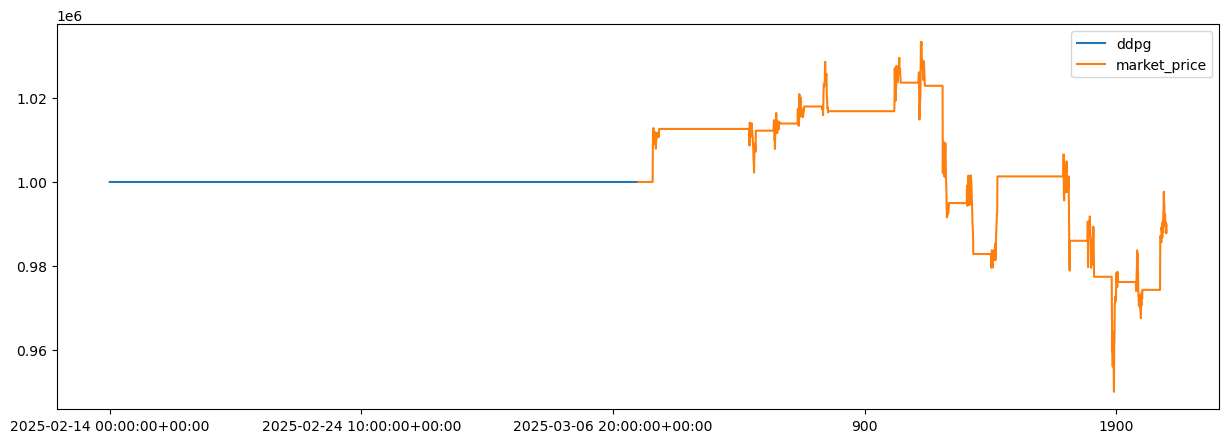

In [96]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15, 5)
plt.figure()
result.plot()
plt.show()

In [97]:
# print(df_aapl['close'].isna().sum())  # 检查 'close' 列中是否有缺失值
# print(df_aapl.shape)  # 查看数据的行数


In [98]:
# import pandas as pd
# import talib

# # 假设 df_aapl 已经是按 15 分钟时间间隔的数据，并且包含了 'close' 列

# # 确保 'datetime' 列是正确的 datetime 格式
# # df_aapl['datetime'] = pd.to_datetime(df_aapl['datetime'])

# # 填充缺失的 close 值（如果有的话）
# df_aapl['close'] = df_aapl['close'].fillna(method='ffill')

# # 检查数据是否足够
# if len(df_aapl) < 26:
#     print("数据点不足以计算 MACD 和 RSI")
# else:
#     # 计算 MACD 指标
#     df_aapl['macd'], df_aapl['macd_signal'], df_aapl['macd_hist'] = talib.MACD(
#         df_aapl['close'], fastperiod=12, slowperiod=26, signalperiod=9
#     )

#     # 计算 RSI 指标
#     df_aapl['rsi'] = talib.RSI(df_aapl['close'], timeperiod=14)

#     # 打印计算后的数据
#     print(df_aapl.head())
#     print(df_aapl.tail())


In [99]:
# df_aapl = df_aapl.dropna(subset=['macd', 'macd_signal', 'macd_hist', 'rsi'])
# df_aapl = df_aapl.reset_index(drop=True)
# print(df_aapl.head(15))
# print(df_aapl.tail())

In [100]:
# split_date = '2025-02-25 16:15:00+00:0'
# train = df_aapl[df_aapl['date'] < split_date].reset_index(drop=True)
# trade = df_aapl[df_aapl['date'] >= split_date].reset_index(drop=True)

In [101]:
# train.to_csv('train_data.csv')
# trade.to_csv('trade_data.csv')